In [1]:
import pandas as pd
import re
import string
import pickle
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score,StratifiedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import fbeta_score, make_scorer
import seaborn as sns

### Import excel file for levant countries

In [2]:
df=pd.read_excel("data_levant.xlsx",index_col=0,
              dtype={'tokens': str, 'dialect': str})

In [3]:
df

,tokens,dialect
83065,جمعتهم بالصرمايه عصبن شارب عادل الجبير,PL
83066,سود الله وجه ال سعود زراق وحوههم,PL
83067,كلام الليل مدهون بزبده وان طلع النهار بسسيح,PL
83068,مين الي شاغل بالك سميرا يا صغيره عبر,PL
83069,منصوره,PL
...,...,...
329945,خائن حبيب صار الوقت,LB
329946,المقاومه باقيه باقيه باقيه صوت المقاومه وصداها,LB
329947,ليش بتزلو عالضاحيه نمر زرقا عم تشتغل تاكسي,LB
329948,بحبك بس بعرف مش الي,LB


### Checking null values

In [4]:
df.isnull().sum()

tokens     0
dialect    0
dtype: int64

Index(['PL', 'JO', 'LB', 'SY'], dtype='object')


D:\anaconda1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='dialect'>

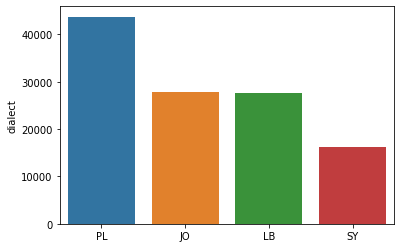

In [5]:
x=df['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

### Building voting classifier (linearsvc, multinomialNB, BernoulliNB)

In [6]:
def build_estimators():
    estimators = []
    svc = LinearSVC(penalty='l1', dual=False,tol=1e-3)
    estimators.append(('svc',svc))
    mnb= MultinomialNB(alpha=.01)
    estimators.append(('mnb',mnb))
    bnb= BernoulliNB(alpha=.01)
    estimators.append(('bnb',bnb))
    ensemble = VotingClassifier(estimators)
    return ensemble

### train, validation,test split

In [7]:
x=df['tokens']
y=df['dialect']
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.1,stratify=y,random_state=42)
X_train1, X_valid, y_train1, y_valid=train_test_split(X_train, y_train,test_size=0.1,stratify=y_train,random_state=42)

In [8]:
target_names=list(y_train1.unique())

In [9]:
# featureunion -> combines several transformer objects into a new transformer that combines their output. 
# A FeatureUnion takes a list of transformer objects. During fitting, each of these is fit to the data independently.
# For transforming data, the transformers are applied in parallel, and 
# the sample vectors they output are concatenated end-to-end into larger vectors.

### Extracting features from the training data using a Tfidf-vectorizer

In [10]:

# featureunion -> concatenate the results of multiple transformer objects,combine several feature extraction mechanisms
#into a single transformer.
max_df = 0.5
union = FeatureUnion([("w_v", TfidfVectorizer(sublinear_tf=True, max_df=max_df,analyzer = 'word', ngram_range=(1,3)
                                 )),

                       ("c_wb", TfidfVectorizer(sublinear_tf=True,max_df=max_df,analyzer = 'char_wb', ngram_range=(2,5)
                                 )),

                      ("c_wb5", TfidfVectorizer(sublinear_tf=True, max_df=max_df,analyzer = 'char', ngram_range=(2,4)
                                 )),

                       ],
transformer_weights={
            'w_v': 0.9,
           
            'c_wb': 0.9,
         
           "c_wb5":0.9,
          
        }
,
)



X_train_feat = union.fit_transform(X_train1)
X_valid_feat = union.transform(X_valid)
print("Combined space has", X_train_feat.shape[1], "features")
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_feat, y_train1)


Combined space has 2009588 features


### Training the classifier

In [11]:
ensemble = build_estimators()
ensemble.fit(X_res, y_res)



VotingClassifier(estimators=[('svc',
                              LinearSVC(dual=False, penalty='l1', tol=0.001)),
                             ('mnb', MultinomialNB(alpha=0.01)),
                             ('bnb', BernoulliNB(alpha=0.01))])

### Testing the classifier on validation data

In [12]:
pred = ensemble.predict(X_valid_feat)
 
# print("Combined space has", X_train.shape[1], "features")



score = metrics.accuracy_score(y_valid, pred)
print("accuracy:   %0.3f" % score)

print("classification report:")
print(metrics.classification_report(y_valid, pred,target_names=target_names))

print("confusion matrix:")
print(metrics.confusion_matrix(y_valid, pred))

accuracy:   0.648
classification report:
              precision    recall  f1-score   support

          PL       0.57      0.52      0.54      2512
          JO       0.73      0.73      0.73      2485
          LB       0.65      0.76      0.70      3936
          SY       0.62      0.41      0.49      1461

    accuracy                           0.65     10394
   macro avg       0.64      0.61      0.62     10394
weighted avg       0.64      0.65      0.64     10394

confusion matrix:
[[1310  141  956  105]
 [ 186 1824  335  140]
 [ 584  223 2997  132]
 [ 217  311  329  604]]


### Testing the classifier on testing data

In [13]:
X_test_feat = union.transform(X_test)
pred_test=ensemble.predict(X_test_feat)
score = metrics.accuracy_score(y_test, pred_test)
print("accuracy:   %0.3f" % score)
print("classification report:")
print(metrics.classification_report(y_test, pred_test,target_names=target_names))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, pred_test))

accuracy:   0.642
classification report:
              precision    recall  f1-score   support

          PL       0.56      0.54      0.55      2791
          JO       0.73      0.72      0.72      2762
          LB       0.65      0.75      0.69      4373
          SY       0.60      0.40      0.48      1623

    accuracy                           0.64     11549
   macro avg       0.64      0.60      0.61     11549
weighted avg       0.64      0.64      0.64     11549

confusion matrix:
[[1503  164 1012  112]
 [ 218 1988  401  155]
 [ 688  257 3265  163]
 [ 273  316  377  657]]


### Testing the model on some sentences

In [14]:

ensemble.predict(union.transform(["معنعن"]))

array(['PL'], dtype=object)

In [16]:
pickle.dump(ensemble,open('model_levant.pkl','wb'))

In [17]:
pickle.dump(union,open('union_levant.pkl','wb'))